Đang load dữ liệu...
Train shape: (1098195, 46), Test shape: (200000, 46)
Thiết bị: cuda
Đang train Autoencoder...
Epoch 10/100 - Loss: 0.025696
Epoch 20/100 - Loss: 0.018567
Epoch 30/100 - Loss: 0.017040
Epoch 40/100 - Loss: 0.011410
Epoch 50/100 - Loss: 0.009651
Epoch 60/100 - Loss: 0.008843
Epoch 70/100 - Loss: 0.008643
Epoch 80/100 - Loss: 0.008626
Epoch 90/100 - Loss: 0.008512
Epoch 100/100 - Loss: 0.008496
Huấn luyện hoàn tất. Model tốt nhất đã lưu vào best_ae_model.pth

=== Kết quả Anomaly Detection ===
AUC: 0.9758
Accuracy: 0.9252
Precision: 0.9886
Recall: 0.8603
F1-score: 0.9200
Threshold (99th percentile): 0.041483


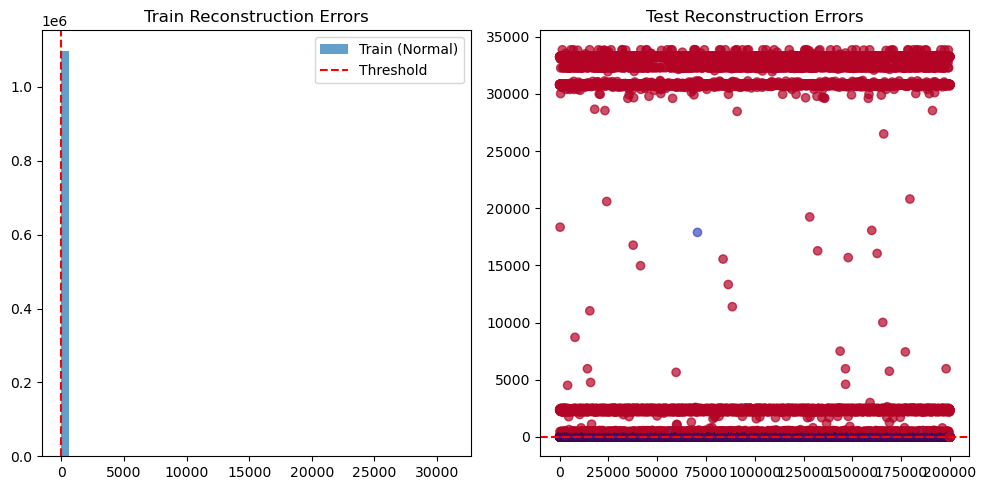

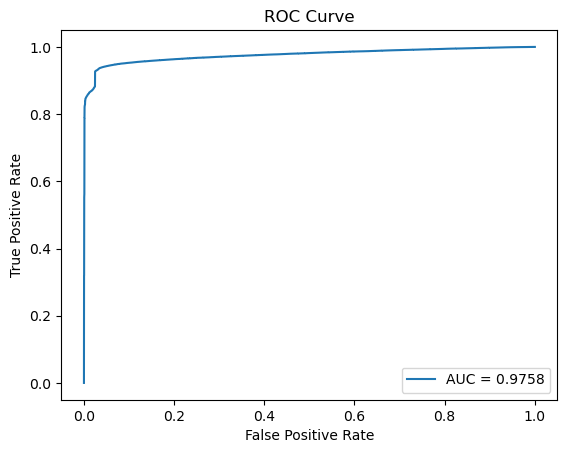

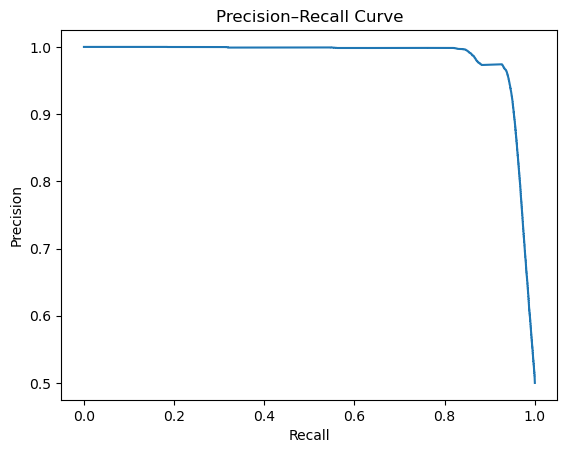

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

# ============================
# 1. Load dữ liệu
# ============================
print("Đang load dữ liệu...")
train_data = pd.read_csv('unsupervised_dataset.csv')  # Chỉ normal samples
test_data = pd.read_csv('evaluation_dataset.csv')     # Có nhãn

X_train = train_data.values
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values
y_test_binary = np.where(y_test == -1, 1, 0)  # 1 = abnormal

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# ============================
# 2. Normalize
# ============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Thiết bị:", device)

# ============================
# 3. Autoencoder cho Anomaly Detection
# ============================
class ImprovedAnomalyAE(nn.Module):
    def __init__(self, input_dim=46, latent_dim=8):
        super(ImprovedAnomalyAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        reconstructed = self.decoder(z)
        return reconstructed

# ============================
# 4. Train AE
# ============================
model = ImprovedAnomalyAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

EPOCHS = 100
best_loss = float('inf')
early_stop_patience = 10
no_improve = 0

print("Đang train Autoencoder...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for (x_batch,) in train_loader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        reconstructed = model(x_batch)
        loss = criterion(reconstructed, x_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    scheduler.step(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "best_ae_model.pth")
        no_improve = 0
    else:
        no_improve += 1

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.6f}")
    if no_improve >= early_stop_patience:
        print("Early stopping!")
        break

print("Huấn luyện hoàn tất. Model tốt nhất đã lưu vào best_ae_model.pth")

# ============================
# 5. Đánh giá
# ============================
model.load_state_dict(torch.load("best_ae_model.pth"))
model.eval()

with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    reconstructed = model(X_test_tensor)
    mse_errors = torch.mean((X_test_tensor - reconstructed)**2, dim=1).cpu().numpy()

with torch.no_grad():
    train_reconstructed = model(X_train_tensor.to(device))
    train_errors = torch.mean((X_train_tensor.to(device) - train_reconstructed)**2, dim=1).cpu().numpy()

# Threshold theo percentile 99
threshold = np.percentile(train_errors, 99)
y_pred_binary = (mse_errors > threshold).astype(int)

# ============================
# 6. Evaluation metrics
# ============================
auc = roc_auc_score(y_test_binary, mse_errors)
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_binary, y_pred_binary, average='binary')

print("\n=== Kết quả Anomaly Detection ===")
print(f"AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Threshold (99th percentile): {threshold:.6f}")

# ============================
# 7. Biểu đồ trực quan
# ============================
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(train_errors, bins=50, alpha=0.7, label='Train (Normal)')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.legend()
plt.title('Train Reconstruction Errors')

plt.subplot(1, 2, 2)
plt.scatter(range(len(mse_errors)), mse_errors, c=y_test_binary, cmap='coolwarm', alpha=0.7)
plt.axhline(threshold, color='r', linestyle='--')
plt.title('Test Reconstruction Errors')
plt.tight_layout()
plt.savefig("anomaly_detection_improved.png")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_binary, mse_errors)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_test_binary, mse_errors)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


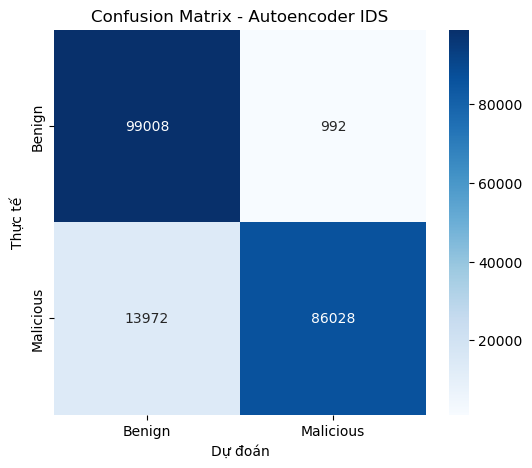

In [5]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.xlabel("Dự đoán")
plt.ylabel("Thực tế")
plt.title("Confusion Matrix - Autoencoder IDS")
plt.show()